# "NMT by Jointly Learning to Align and Translate" Implementation

original paper: https://arxiv.org/abs/1409.0473

references
* arichitecture picture: https://arxiv.org/pdf/1703.03906.pdf
* tutorial: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb
* data source: http://www.statmt.org/wmt14/translation-task.html
* data source2: http://www.manythings.org/anki/

In [1]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, Iterator, BucketIterator, TabularDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from decoder import Decoder
from encoder import Encoder
from attention import Attention
from train import evaluation
# others
import argparse
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.cuda.current_device()
# USE_CUDA = False
# DEVICE = -1

## argparse

In [3]:
parser = argparse.ArgumentParser(description='NMT argument parser')
parser.add_argument('-pth', '--PATH', help='location of path', type=str, default='./data/en_fa/')
parser.add_argument('-trp', '--TRAIN_FILE', help='location of training path', type=str, default='eng-fra-small.train')
parser.add_argument('-vap', '--VALID_FILE', help='location of valid path', type=str, default='eng-fra-small.valid')
parser.add_argument('-tep', '--TEST_FILE', help='location of test path', type=str, default='eng-fra-small.test')
parser.add_argument('-mth', '--METHOD', help='attention methods: dot, general, concat, paper', type=str, default='general')
parser.add_argument('-svpe', '--SAVE_ENC_PATH', help='saving encoder model path', type=str, default='./data/model/fra_eng.enc')
parser.add_argument('-svpd', '--SAVE_DEC_PATH', help='saving decoder model path', type=str, default='./data/model/fra_eng.dec')
parser.add_argument('-bat', '--BATCH', help='batch size', type=int, default=128)
parser.add_argument('-hid', '--HIDDEN', help='hidden size', type=int, default=600)
parser.add_argument('-hid2', '--HIDDEN2', help='hidden size used for attention(not nessesary)', type=int, default=None)
parser.add_argument('-emd', '--EMBED', help='embed size', type=int, default=300)
parser.add_argument('-stp', '--STEP', help='number of iteration', type=int, default=200)
parser.add_argument('-nhl', '--NUM_HIDDEN', help='number of hidden layers', type=int, default=3)
parser.add_argument('-lr', '--LR', help='learning rate', type=float, default=0.001)
config = parser.parse_known_args()[0]

In [4]:
SOURCE = Field(tokenize=str.split, use_vocab=True, init_token="<s>", eos_token="</s>", lower=True, 
                   include_lengths=True, batch_first=True)
TARGET = Field(tokenize=str.split, use_vocab=True, init_token="<s>", eos_token="</s>", lower=True, 
               batch_first=True)

train_data, valid_data, test_data = \
        TabularDataset.splits(path=config.PATH, format='tsv', train=config.TRAIN_FILE, \
                              validation=config.VALID_FILE, test=config.TEST_FILE, \
                              fields=[('so', SOURCE), ('ta', TARGET)])

SOURCE.build_vocab(train_data)
TARGET.build_vocab(train_data)

test_loader = BucketIterator(test_data, batch_size=config.BATCH, device=DEVICE,
                              sort_key=lambda x: len(x.so), sort_within_batch=True, repeat=False)

# vocaburary
V_so = len(SOURCE.vocab)
V_ta = len(TARGET.vocab)

print('train data: {}, valid_data: {}, test_data: {}'.format(len(train_data), len(valid_data), len(test_data)))
print('source language vocab: {}, target language vocab: {}'.format(V_so, V_ta))

train data: 47500, valid_data: 1250, test_data: 1250
source language vocab: 5795, target language vocab: 10027


## architecture

![](./pics/encoder_decoder_att.png)

---

## Build Networks

In [5]:
enc = Encoder(V_so, config.EMBED, config.HIDDEN, config.NUM_HIDDEN, bidrec=True)
dec = Decoder(V_ta, config.EMBED, 2*config.HIDDEN, hidden_size2=config.HIDDEN2, \
              sos_idx=SOURCE.vocab.stoi['<s>'], method=config.METHOD)
if USE_CUDA:
    enc = enc.cuda()
    dec = dec.cuda()

loss_function = nn.CrossEntropyLoss(ignore_index=TARGET.vocab.stoi['<pad>'])

## Load model parameters

In [29]:
enc.load_state_dict(torch.load(config.SAVE_ENC_PATH))
dec.load_state_dict(torch.load(config.SAVE_DEC_PATH))

RuntimeError: Error(s) in loading state_dict for Encoder:
	While copying the parameter named "embed.weight", whose dimensions in the model are torch.Size([5795, 300]) and whose dimensions in the checkpoint are torch.Size([5527, 300]).

## Test

In [6]:
test_losses = evaluation(enc, dec, loss_function, loader=test_loader)
print('test_losses: {}'.format(np.mean(test_losses)))

test_losses: 9.207146835327148


## Visualize Attention

In [7]:
# borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

In [8]:
def print_sentence(x):
    return [i for i in x if i not in ['<s>', '</s>']]

Source :  how many does he want ?
Truth :  combien veut il ?
Prediction :  dresseur emmerde chanteur endroits apparition restes puait qui chauffage gueule repit extravertis soir humeur archeologue imprecis seules ennuyeuses evites mentis stupefiant approche audacieuses touristes agacant ouvrages fiee ajuste egarames ajuste egarames chatouilleuse composition habillez ressent rejoignez trous menton aimions geniaux vipere sottises fourre coherent laisser laisser exemplaire genees sauvee charmantes


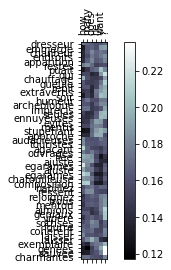

In [12]:
enc.eval()
dec.eval()

test = random.choice(train_data)
source_sentence = test.so
target_sentence = test.ta

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

output, hidden = enc(s, [s.size(1)])
pred, attn = dec.decode(hidden, output, [s.size(1)])
pred_sentence = [TARGET.vocab.itos[i] for i in pred]


print('Source : ', ' '.join(print_sentence(source_sentence)))
print('Truth : ', ' '.join(print_sentence(target_sentence)))
print('Prediction : ', ' '.join(print_sentence(pred_sentence)))

if USE_CUDA:
    attn = attn.cpu()

show_attention(source_sentence, pred_sentence, attn.data)